In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
from scipy.stats import binned_statistic
import math

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

In [2]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.) 

In [3]:
cvfolds = 10
data = np.load("R2192_models/window_scan_R2192_1x1400_predictions_v1.npz")

print type(data), data.keys()

pred_y = data["preds"]
y = data["targets"]
targets = data["targets"]

print pred_y.shape, targets.shape

seqlen = pred_y.shape[1]
pred_y = pred_y.reshape((-1, 2))
print pred_y.shape, seqlen, np.min(pred_y), np.max(pred_y)

<class 'numpy.lib.npyio.NpzFile'> ['preds', 'targets']
(4414, 2) (4414, 2)
(4414, 2) 2 6.38608646393 106.473327637


In [4]:
#y = np.loadtxt("data/R2192_RNN_data_2x400_at19_step200_bin100-RAW_pos.dat")
#y = y[:pred_y.shape[0]]
#print y.shape, np.min(y), np.max(y)

In [5]:
def mse(y, t, axis=2):
    return (np.square(y - t).mean(axis=axis).mean())

def mean_distance(y, t, axis=2):
    return np.mean(np.sqrt(np.sum((y - t)**2, axis=axis)))

def median_distance(y, t, axis=2):
    return np.median(np.sqrt(np.sum((y - t)**2, axis=axis)))

In [6]:
print mse(pred_y[:1100], y[:1100], axis=1), mean_distance(pred_y[:1100], y[:1100], axis=1)
print mse(pred_y[4400:], y[4400:], axis=1), mean_distance(pred_y[:], y[:], axis=1)

99.0925830724 11.6486476409
83.8646764648 12.0698918557


In [7]:
errors = np.sqrt(np.sum((pred_y - y)**2, axis=1))
print np.mean(errors), errors.shape

12.0698918557 (4414,)


In [8]:
# WHAT IS CHANCE LEVEL ACCURACY?
r_y = y.copy()
np.random.shuffle(r_y)
print mean_distance(r_y[:], y[:], axis=1), median_distance(r_y[:], y[:], axis=1)

print np.mean(y,keepdims=True)
print mean_distance(np.mean(y,keepdims=True), y[:], axis=1), median_distance(np.mean(y,keepdims=True), y[:], axis=1)


49.0557075699 46.7949687299
[[ 58.40385763]]
35.2527799872 37.1498338228


we have in total error size:  (10, 4414, 2) (10, 4414) 12.5291209024
avg_errors shape (4414,) 12.5291209024 10.501569161
avg_pred shape (4414, 2)
101.583849747 11.7289079193
Ensemble errors for full model (mean, median, shape) 11.7289079193 9.8385293879 (4414,)


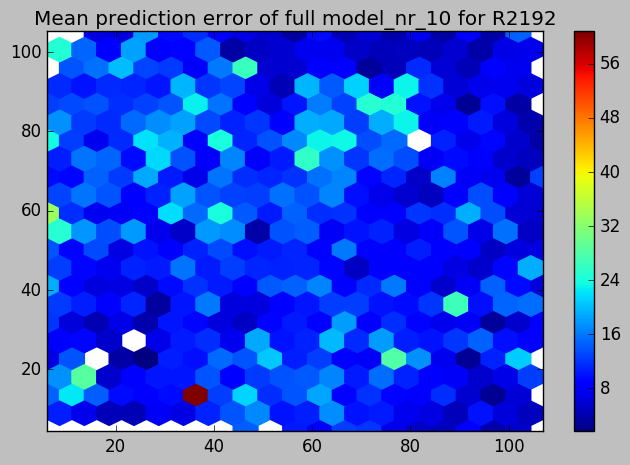

In [9]:
all_preds = []
all_errors =[]
#tagerts are always the same though

for i in range(1,11):
    data = np.load("R2192_models/window_scan_R2192_1x1400_predictions_v"+str(i)+".npz")
    pr_i = data["preds"]
    tgts = data["targets"]
    assert np.all(tgts==targets) #should always be same
    
    all_preds.append(pr_i)
    errors_i = np.sqrt(np.sum((pr_i - y)**2, axis=1))
    all_errors.append(errors_i) # we record errors of each model individually, not the error made by ensemble model	
    plt.clf()
    plt.figure(figsize=(8,5))
    plt.title("Mean prediction error of full model_nr_"+str(i)+" for R2192")
    plt.hexbin(y[:,0], y[:,1], C=errors_i, gridsize=20, reduce_C_function = np.median)
    plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
    plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
    plt.colorbar();
    #plt.show()
    
print "we have in total error size: ", np.shape(all_preds), np.shape(all_errors), np.mean(np.ravel(all_errors))
avg_pred = np.mean(all_preds,axis=0) # this gives us the prediction of ensemble model
avg_errors = np.mean(all_errors,axis=0) #this gives us the average of errors for each location, not error of ensemble model!
median_errors = np.median(all_errors,axis=0)

print "avg_errors shape", np.shape(avg_errors), np.mean(avg_errors), np.median(avg_errors)
print "avg_pred shape", np.shape(avg_pred)


#calculating errors for ensemble model
print mse(avg_pred[:], y[:], axis=1), mean_distance(avg_pred[:], y[:], axis=1)
ensemble_errors = np.sqrt(np.sum((avg_pred - y)**2, axis=1))
print "Ensemble errors for full model (mean, median, shape)", np.mean(ensemble_errors),np.median(ensemble_errors), ensemble_errors.shape
np.save("predictions_by_ensemble_of_10_R2335models.npy", avg_pred)


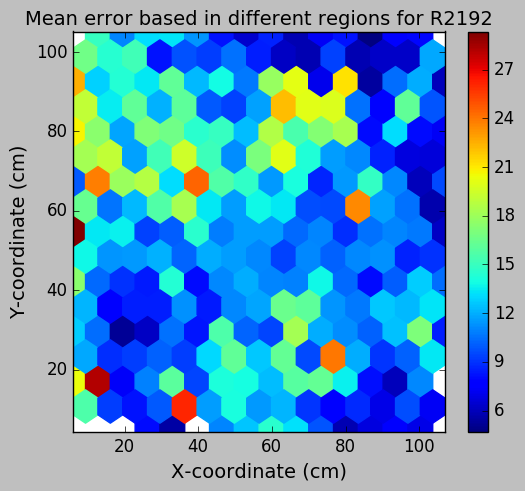

In [10]:
plt.figure(figsize=(6,5))
plt.title("Mean error based in different regions for R2192",fontsize=14)
plt.hexbin(y[:,0], y[:,1],C=avg_errors, gridsize=15)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();
plt.xlabel("X-coordinate (cm)",fontsize=14)
plt.ylabel("Y-coordinate (cm)",fontsize=14)
plt.savefig("../mean_of_means2D.png")
plt.savefig("../mean_of_means2D.eps", format='eps')

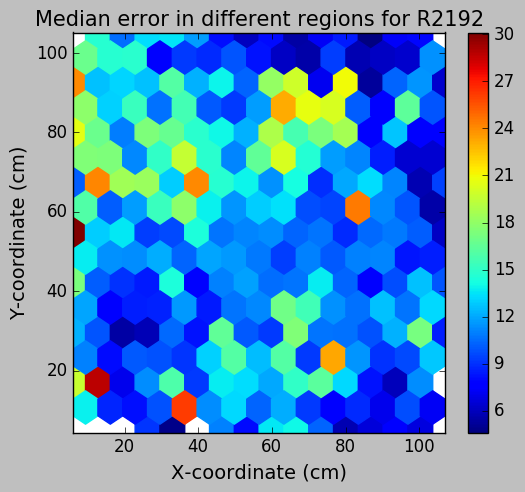

In [11]:
plt.figure(figsize=(6,5))
plt.title("Median error in different regions for R2192",fontsize=15)
median_collection = plt.hexbin(y[:,0], y[:,1],C=median_errors, gridsize=15, reduce_C_function = np.mean)
median_hexes = median_collection.get_array()
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();
plt.xlabel("X-coordinate (cm)",fontsize=14)
plt.ylabel("Y-coordinate (cm)",fontsize=14)
plt.savefig("../mean_of_medians2D.png")
plt.savefig("../mean_of_medians2D.eps", format='eps')

In [12]:
#this would do only the points in test set, not all point and not all training points
"""plt.figure(figsize=(16,10))
plt.title("Visit counts for R2192")
visit_collection = plt.hexbin(y[:,0], y[:,1], gridsize=15)
visit_hexes = visit_collection.get_array()
centers = np.array(visit_collection.get_offsets())
#print np.shape(centers),centers

plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();


plt.scatter(centers[:,0],[centers[:,1]],marker="o")"""

'plt.figure(figsize=(16,10))\nplt.title("Visit counts for R2192")\nvisit_collection = plt.hexbin(y[:,0], y[:,1], gridsize=15)\nvisit_hexes = visit_collection.get_array()\ncenters = np.array(visit_collection.get_offsets())\n#print np.shape(centers),centers\n\nplt.xlim([np.min(y[:,0]), np.max(y[:,0])])\nplt.ylim([np.min(y[:,1]), np.max(y[:,1])])\nplt.colorbar();\n\n\nplt.scatter(centers[:,0],[centers[:,1]],marker="o")'

In [13]:

"""#we have the centers, we want to find where each point belongs to
def closest_node(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

assignements=[]
for yi in y:
    assignements.append(closest_node(yi, centers))

assignements2=[]
for yi in y:
    y_plus = np.vstack((y,yi))
    visit_plus = (plt.hexbin(y_plus[:,0], y_plus[:,1], gridsize=15)).get_array()
    assignements2.append(np.where(visit_plus>visit_hexes)[0].ravel())

    
print np.shape(assignements), np.shape(assignements2)
counts = [assignements2.count(x) for x in range(len(visit_hexes))]
print np.all(counts==visit_hexes)
#print counts, visit_hexes"""


"#we have the centers, we want to find where each point belongs to\ndef closest_node(node, nodes):\n    nodes = np.asarray(nodes)\n    deltas = nodes - node\n    dist_2 = np.einsum('ij,ij->i', deltas, deltas)\n    return np.argmin(dist_2)\n\nassignements=[]\nfor yi in y:\n    assignements.append(closest_node(yi, centers))\n\nassignements2=[]\nfor yi in y:\n    y_plus = np.vstack((y,yi))\n    visit_plus = (plt.hexbin(y_plus[:,0], y_plus[:,1], gridsize=15)).get_array()\n    assignements2.append(np.where(visit_plus>visit_hexes)[0].ravel())\n\n    \nprint np.shape(assignements), np.shape(assignements2)\ncounts = [assignements2.count(x) for x in range(len(visit_hexes))]\nprint np.all(counts==visit_hexes)\n#print counts, visit_hexes"

In [14]:
def min_dist_in_train(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.min(dist_2)

def nearby_in_train(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    ordered = sorted(dist_2)
    ii=0
    while ordered[ii]<10:
        ii+=1
    return ii


raw_y = np.loadtxt("data/R2192_1x1400_at35_step200_bin100-RAW_pos.dat")
raw_feat = np.loadtxt("data/R2192_1x1400_at35_step200_bin100-RAW_feat.dat")
print raw_y.shape
#print raw_y[99:109], y[:10]

closest_points=[]
count_nearby = []
activity=[]
activity2=[] #activity earlier in time
activity3=[] #activity even more early in time

from sklearn.cross_validation import KFold

for i, (rest_idx, test_idx) in enumerate(KFold(raw_y.shape[0], 10)):
    if np.min(test_idx)==0: #first fol left out
        rest_idx = np.array(sorted(rest_idx)[99:])
        test_idx = np.array(sorted(test_idx)[99:])
    elif np.max(test_idx)== raw_y.shape[0]-1: #last fold left out
        rest_idx = np.array(sorted(rest_idx)[99:])
        test_idx = np.array(sorted(test_idx)[99:])
    else:
        assert (np.min(test_idx)>np.min(rest_idx))
        assert (np.max(test_idx)<np.max(rest_idx))
        
        all_idx = np.array(range(raw_y.shape[0]))
        #print all_idx[99:np.min(test_idx)].shape,all_idx[np.max(test_idx)+100:].shape
        rest_idx = np.hstack((all_idx[99:np.min(test_idx)],all_idx[np.max(test_idx)+100:]))
        test_idx = np.array(sorted(test_idx)[99:])
    print "Fold nr ",i," shapes ", test_idx.shape, rest_idx.shape     
    test = raw_y[test_idx]
    rest = raw_y[rest_idx]
    for loc in test:
        closest_points.append(min_dist_in_train(loc,rest))
        count_nearby.append(nearby_in_train(loc,rest))
    # find the lines in activity matrix, sum and append
    test_activity = np.sum(raw_feat[test_idx,:],axis=1)
    test_activity2 = np.sum(raw_feat[test_idx-7,:],axis=1)
    test_activity3 = np.sum(raw_feat[test_idx-14,:],axis=1)
    activity = np.concatenate([activity,test_activity])
    activity2 = np.concatenate([activity2,test_activity2])
    activity3 = np.concatenate([activity3,test_activity3])

print np.shape(activity)      
        
print np.shape(closest_points), np.shape(y), np.shape(avg_errors)
print closest_points[np.argmax(closest_points)], y[np.argmax(closest_points)]


(5404, 2)
Fold nr  0  shapes  (442,) (4764,)


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fold nr  1  shapes  (442,) (4665,)
Fold nr  2  shapes  (442,) (4665,)
Fold nr  3  shapes  (442,) (4665,)
Fold nr  4  shapes  (441,) (4666,)
Fold nr  5  shapes  (441,) (4666,)
Fold nr  6  shapes  (441,) (4666,)
Fold nr  7  shapes  (441,) (4666,)
Fold nr  8  shapes  (441,) (4666,)
Fold nr  9  shapes  (441,) (4765,)
(4414,)
(4414,) (4414, 2) (4414,)
23.58777137 [ 18.9324  24.0952]


(63, 54100) (54100, 2) (54100,)


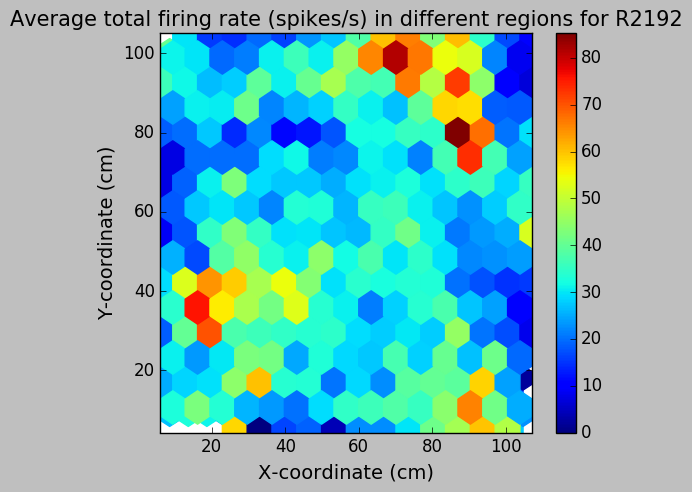

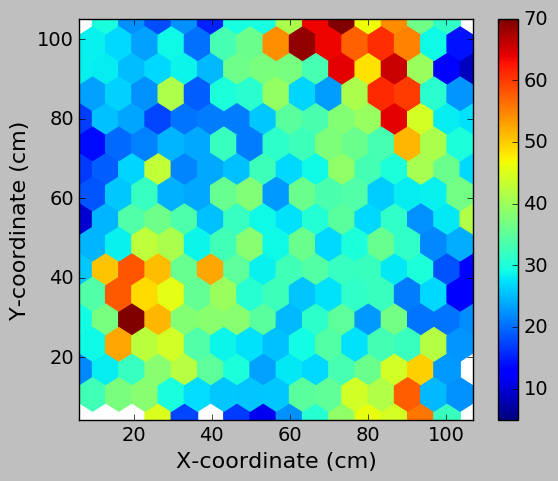

In [15]:
import scipy.io as scio
spike_data=scio.loadmat("../preprocess/R2192/R2192_20ms")['mm']
all_info = scio.loadmat("../preprocess/R2192/R2192_data.mat")
locations = all_info["data"][0][0][4][0][0][3]/3.5
sum_activity = np.sum(spike_data,axis=0)*50
print np.shape(spike_data),np.shape(locations),np.shape(sum_activity)

plt.clf()
plt.figure(figsize=(6,5))
plt.title("Average total firing rate (spikes/s) in different regions for R2192",fontsize=15)
all_raw_collection20 = plt.hexbin(locations[:,0], locations[:,1],C=sum_activity, gridsize = 20)
all_raw_hexes20 = all_raw_collection20.get_array()
all_raw_collection15 = plt.hexbin(locations[:,0], locations[:,1],C=sum_activity, gridsize = 15)
all_raw_hexes15 = all_raw_collection15.get_array()
plt.xlim([np.min(locations[:,0]), np.max(locations[:,0])])
plt.ylim([np.min(locations[:,1]), np.max(locations[:,1])])
plt.xlabel("X-coordinate (cm)",fontsize=14)
plt.ylabel("Y-coordinate (cm)",fontsize=14)
plt.colorbar();
plt.savefig("../mean_activity2D_20ms.png")
plt.savefig("../mean_activity2D_20ms.eps", format='eps')
#print all_raw_hexes15

# This is based on only train set and on 1400ms windows
plt.figure(figsize=(6,5))
#plt.title("Sum neural activity in spikes/s in different regions for R2192",fontsize=15)
plt.hexbin(y[:,0], y[:,1],C=activity/1.4, gridsize=15, vmin=5, vmax=70)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
cbar = plt.colorbar(ticks=[0,10,20,30,40,50,60,70]);
cbar.ax.set_yticklabels([10,20,30,40,50,60,70],fontsize=14)
plt.tight_layout()
plt.savefig("../mean_activity2D_1400ms.png")
plt.savefig("../mean_activity2D_1400ms.eps", format='eps')

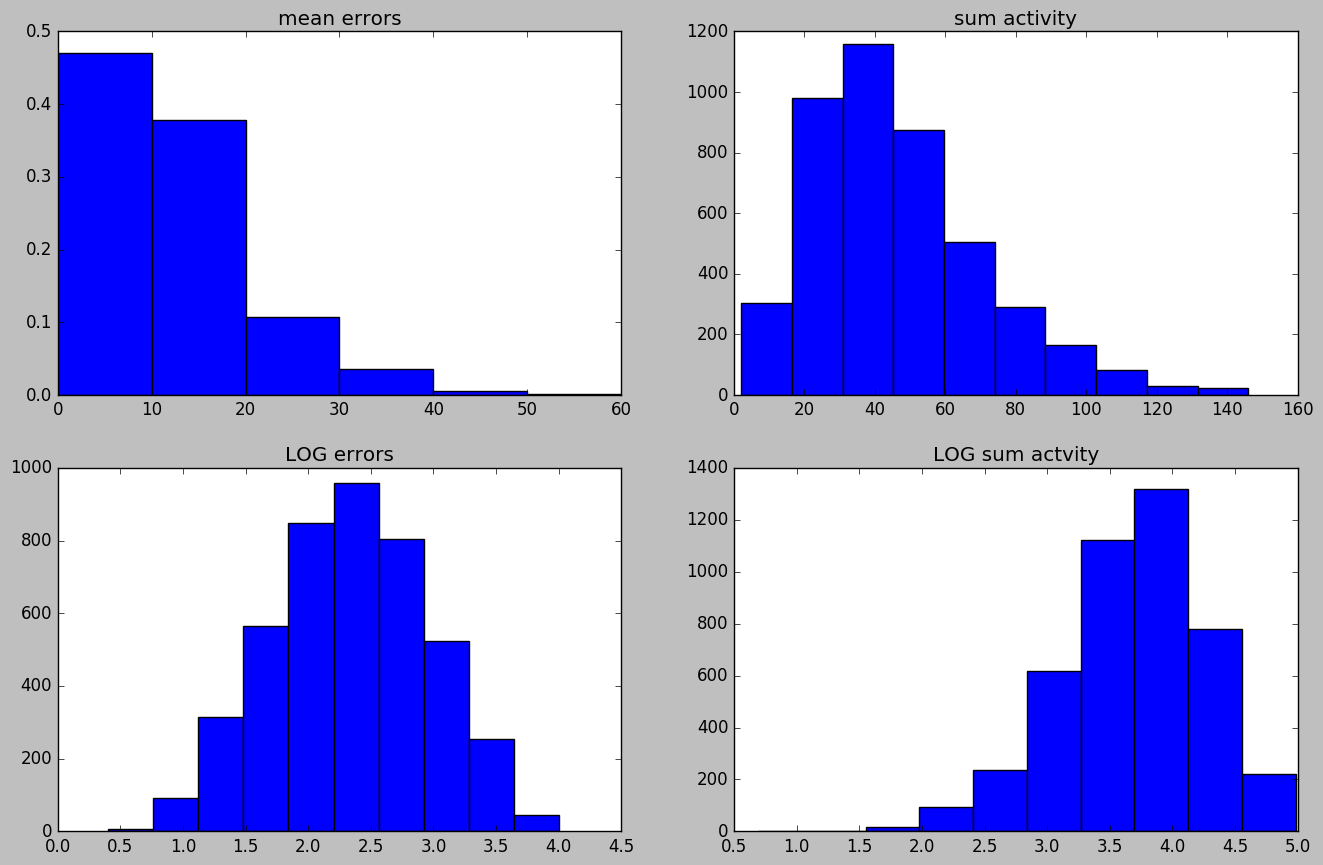

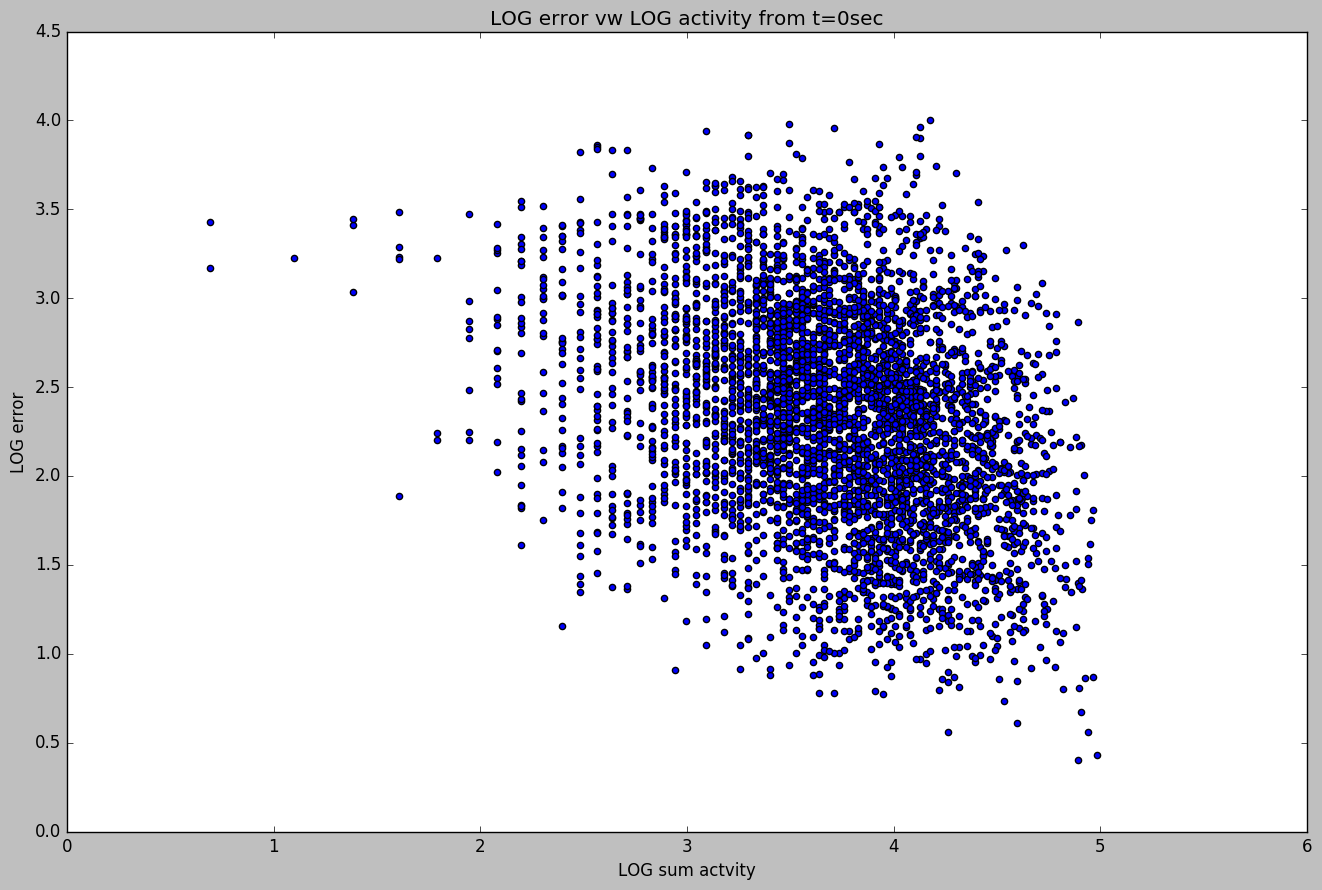

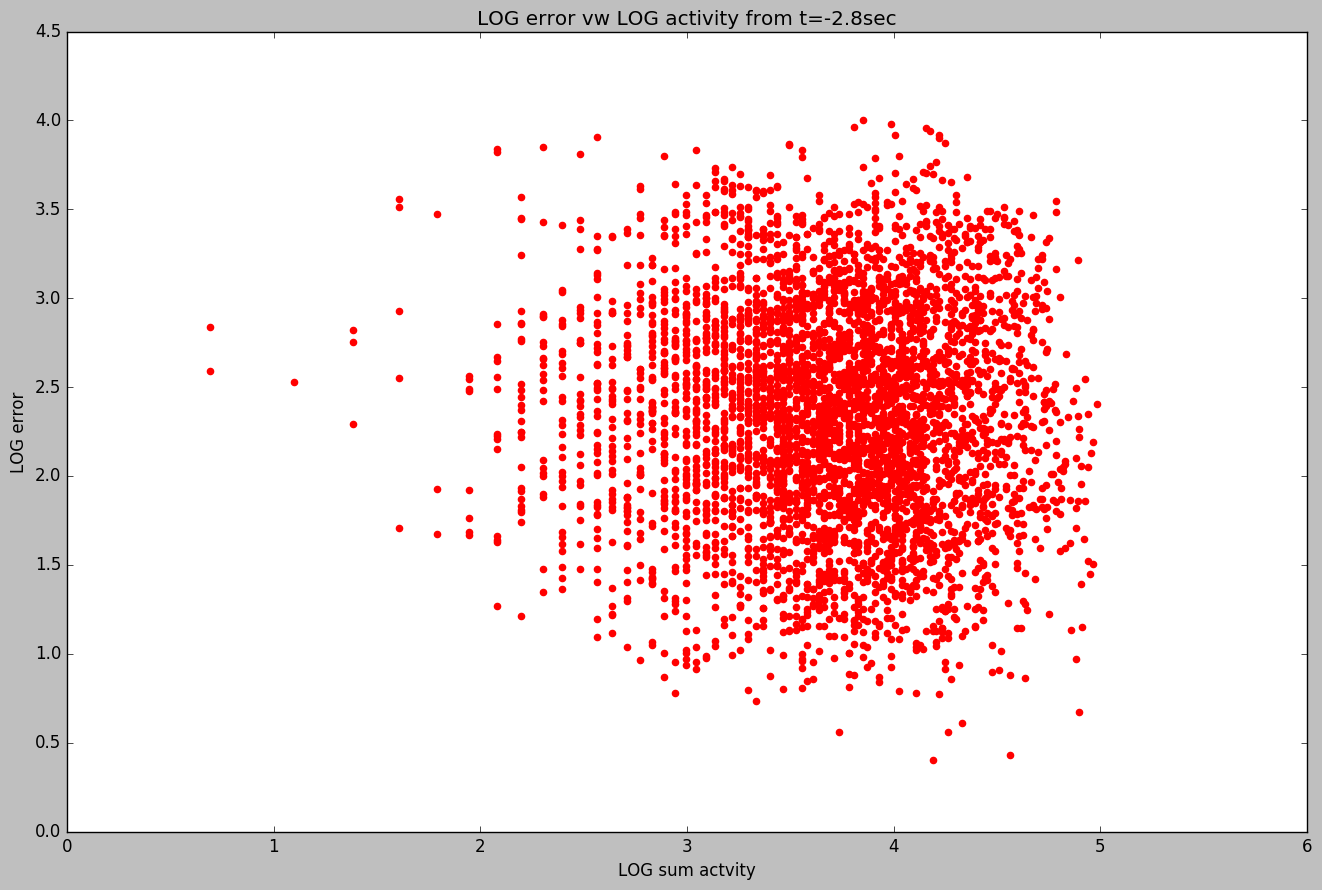

In [16]:
#plt.figure(figsize=(16,10))
#plt.scatter(closest_points, avg_errors)
#plt.show()

#plt.figure(figsize=(16,10))
#plt.scatter(count_nearby, avg_errors)
#plt.show()
plt.figure(figsize=(16,10))

plt.subplot(2,2,1)
plt.hist(avg_errors, bins=[0,10,20,30,40,50,60], weights=np.ones_like(avg_errors)/(len(avg_errors)))
plt.title("mean errors")
plt.subplot(2,2,2)
plt.hist(activity)
plt.title("sum activity")

plt.subplot(2,2,3)
plt.hist(np.log(avg_errors))
plt.title("LOG errors")
plt.subplot(2,2,4)
plt.hist(np.log(activity))
plt.title("LOG sum actvity")
plt.show()

plt.figure(figsize=(16,10))
plt.scatter(np.log(activity), np.log(avg_errors))
plt.title("LOG error vw LOG activity from t=0sec")
plt.ylabel("LOG error")
plt.xlabel("LOG sum actvity")
plt.show()


plt.figure(figsize=(16,10))
plt.scatter(np.log(activity3), np.log(avg_errors), color="red")
plt.title("LOG error vw LOG activity from t=-2.8sec")
plt.ylabel("LOG error")
plt.xlabel("LOG sum actvity")
plt.show()


15.8296307346 12.5291209024
12.1655250606 10.501569161


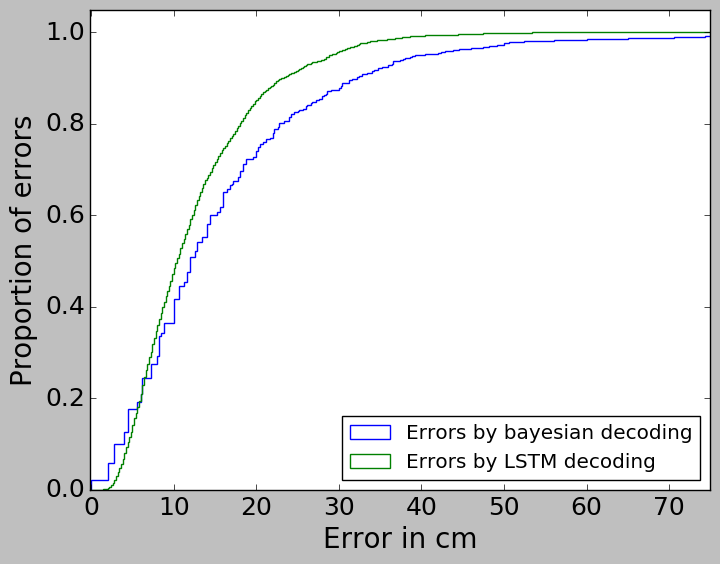

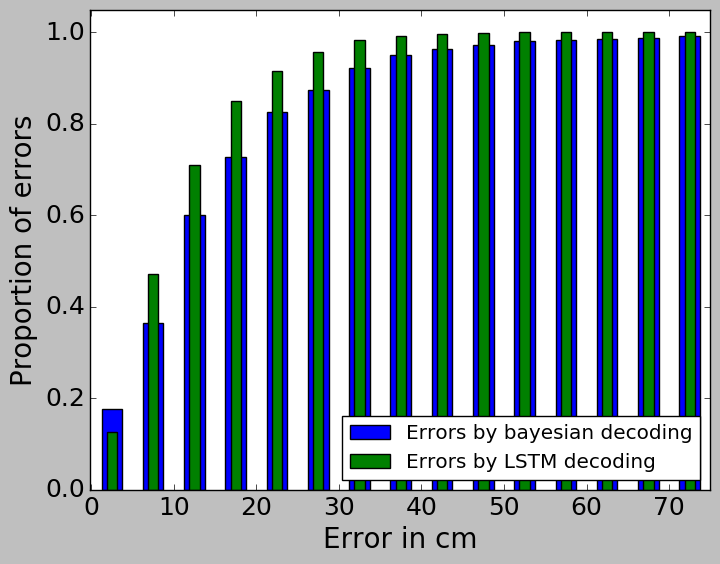

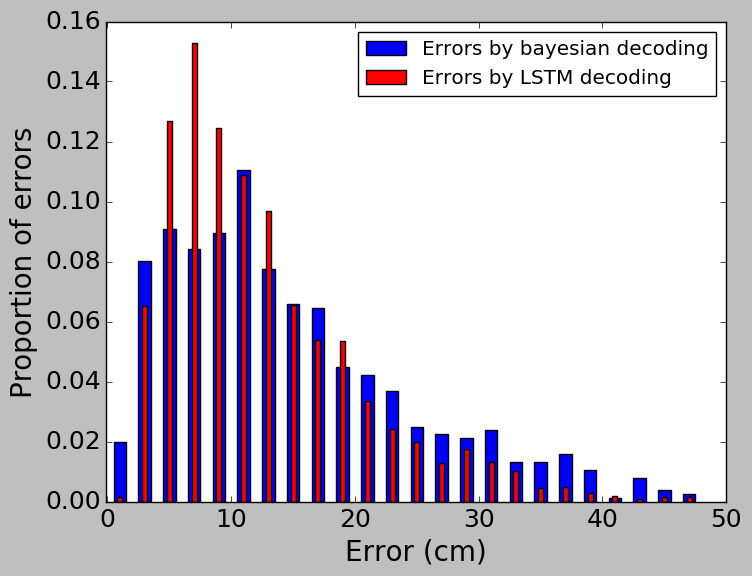

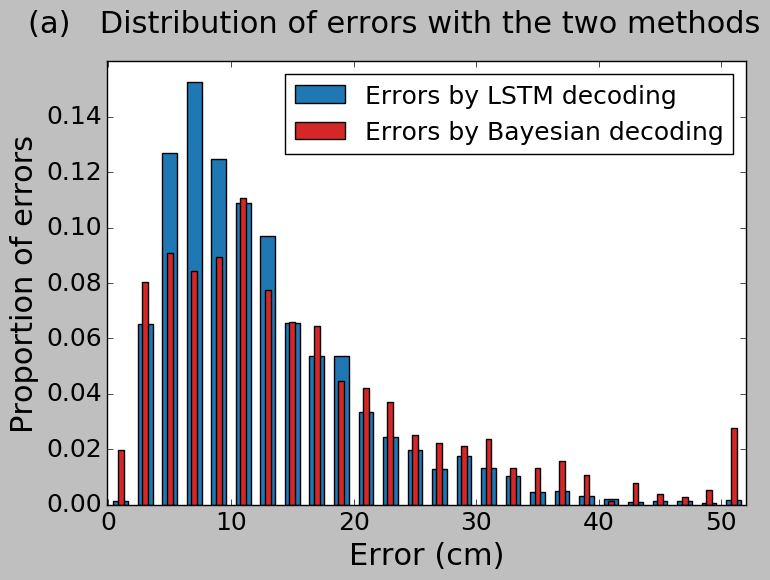

4414 76
4414 7
760 60
760 21


In [17]:
#CASWELL stuff

predR2192 = np.loadtxt("/home/deepmind/projects/new_rat/ratgps/lstm/caswell_res/R2192_2800ms_bayes_pred.txt")
trueR2192 = np.loadtxt("/home/deepmind/projects/new_rat/ratgps/lstm/caswell_res/R2192_2800ms_bayes_true.txt")

errors= np.sqrt(np.sum((predR2192-trueR2192)**2,axis=1))
errors_clipped= np.clip(errors,0,50)

print np.mean(errors),np.mean(avg_errors)
print np.median(errors),np.median(avg_errors)


plt.hist(errors,bins=np.arange(0,80,0.2),histtype="step",align="mid",rwidth=0.5, weights=np.ones_like(errors)/len(errors),label="Errors by bayesian decoding",cumulative=True)
plt.hist(avg_errors, bins=np.arange(0,80,0.2),histtype="step",align="mid",rwidth=0.25, weights=np.ones_like(avg_errors)/(len(avg_errors)),label="Errors by LSTM decoding",cumulative=True)
plt.legend(loc=4)
plt.xlabel("Error in cm",fontsize=20)
plt.ylabel("Proportion of errors",fontsize=20)
plt.xlim(-0.1,75)
plt.ylim(0,1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


plt.clf()
plt.hist(errors,bins=np.arange(0,80,5),align="mid",rwidth=0.5, weights=np.ones_like(errors)/len(errors),label="Errors by bayesian decoding",cumulative=True)
plt.hist(avg_errors, bins=np.arange(0,80,5),align="mid",rwidth=0.25, weights=np.ones_like(avg_errors)/(len(avg_errors)),label="Errors by LSTM decoding",cumulative=True)
plt.legend(loc=4)
plt.xlabel("Error in cm",fontsize=20)
plt.ylabel("Proportion of errors",fontsize=20)
plt.xlim(-0.1,75)
plt.ylim(0,1.05)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

plt.clf()
plt.hist(errors,bins=np.arange(0,50,2),align="mid",rwidth=0.5, weights=np.ones_like(errors)/len(errors),label="Errors by bayesian decoding")
plt.hist(avg_errors, bins=np.arange(0,50,2), color="red",align="mid",rwidth=0.2, weights=np.ones_like(avg_errors)/(len(avg_errors)),label="Errors by LSTM decoding")
plt.legend(loc=1)
plt.xlabel("Error (cm)",fontsize=20)
plt.ylabel("Proportion of errors",fontsize=20)
plt.xlim(-0.1,50)
plt.ylim(0,0.16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


plt.figure(figsize=(8,6))

plt.clf()
plt.hist(np.clip(avg_errors,0,52), bins=np.arange(0,52.1,2), color=tableau20[0],align="mid",rwidth=0.6, weights=np.ones_like(avg_errors)/(len(avg_errors)),label="Errors by LSTM decoding")
plt.hist(np.clip(errors,0,52),bins=np.arange(0,52.1,2),color=tableau20[6], align="mid",rwidth=0.24, weights=np.ones_like(errors)/len(errors),label="Errors by Bayesian decoding")
plt.legend(loc=1,fontsize=18)
plt.title("(a)   Distribution of errors with the two methods", fontsize=22,y=1.05,x=0.45)
plt.xlabel("Error (cm)",fontsize=22)
plt.ylabel("Proportion of errors", fontsize=22)
plt.xlim(-0.1,52)
plt.ylim(0,0.16)
plt.xticks(fontsize=18)
plt.yticks([0.0,0.02,0.04,0.06,0.08,0.10,0.12,0.14],fontsize=18)
plt.tight_layout()
plt.savefig("f3a.png")
plt.show()


print len(avg_errors), np.sum(avg_errors>35)
print len(avg_errors), np.sum(avg_errors>50)


print len(errors), np.sum(errors>35)
print len(errors), np.sum(errors>50)

In [18]:
from scipy.stats import pearsonr,spearmanr

print np.shape(closest_points),np.shape(count_nearby),np.shape(activity)

#print np.corrcoef(closest_points,avg_errors)
#print np.corrcoef(count_nearby,avg_errors)
print "activity now",np.corrcoef(activity,avg_errors)[0][1]
print "activity in the past", np.corrcoef(activity2,avg_errors)[0][1]
print "activity a lot in the past", np.corrcoef(activity3,avg_errors)[0][1]

#print np.corrcoef(np.log(activity),np.log(avg_errors))[0][1]
#print np.corrcoef(np.log(activity3),np.log(avg_errors))[0][1]
print "\n peasron for LOG activity vs error", pearsonr(np.log(activity),np.log(avg_errors))
print "\n spearman activity vs error", spearmanr(activity,avg_errors)
print "\n spearman nr neighbours vs error", spearmanr(count_nearby,avg_errors)

print "\n spearman (nr neighbours vs activity)", spearmanr(count_nearby,activity)



#plt.plot(range(500), avg_errors[:500])

(4414,) (4414,) (4414,)
activity now -0.288458520392
activity in the past -0.0988741765588
activity a lot in the past -0.0148290299867

 peasron for LOG activity vs error (-0.32037498028725342, 6.569038627440173e-106)

 spearman activity vs error SpearmanrResult(correlation=-0.31485083482862447, pvalue=3.6655195013652577e-102)

 spearman nr neighbours vs error SpearmanrResult(correlation=-0.16043880723926895, pvalue=7.7056309883812914e-27)

 spearman (nr neighbours vs activity) SpearmanrResult(correlation=0.011982594170028815, pvalue=0.42608901104986374)


In [19]:
plt.figure(figsize=(16,9))
print np.shape(visit_hexes),np.shape(median_hexes)
nonzero = visit_hexes[visit_hexes != 0]

print "spearman nr neighbours", spearmanr(nonzero,median_hexes)

plt.scatter(nonzero, median_hexes)
plt.title("Visit count vs median error")
plt.show()

NameError: name 'visit_hexes' is not defined

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Visit counts for R2192")
visit_collection = plt.hexbin(y[:,0], y[:,1], gridsize=20)
visit_hexes = visit_collection.get_array()
visit_hexes = visit_hexes[visit_hexes != 0]


plt.figure(figsize=(8,5))
plt.title("Mean prediction error of 10 full models for R2192")
means_collection = plt.hexbin(y[:,0], y[:,1],C=avg_errors, gridsize=20, vmax=30)
means_hexes= means_collection.get_array()
plt.colorbar()
print "spearman nr neighbours", spearmanr(visit_hexes,means_hexes)


In [ ]:
plt.figure(figsize=(16,9))
plt.scatter(y[:,0], y[:,1],c=avg_errors)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();
plt.title("Errors over arena (cm)")

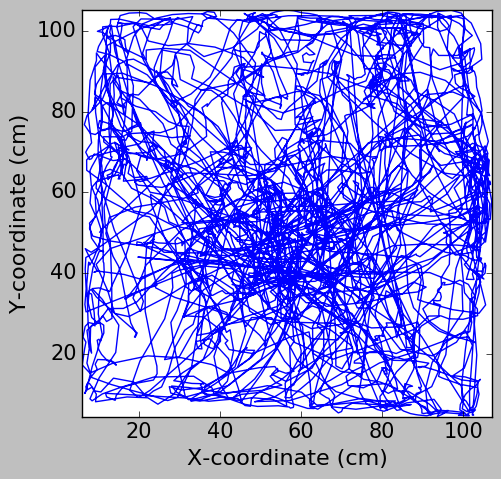

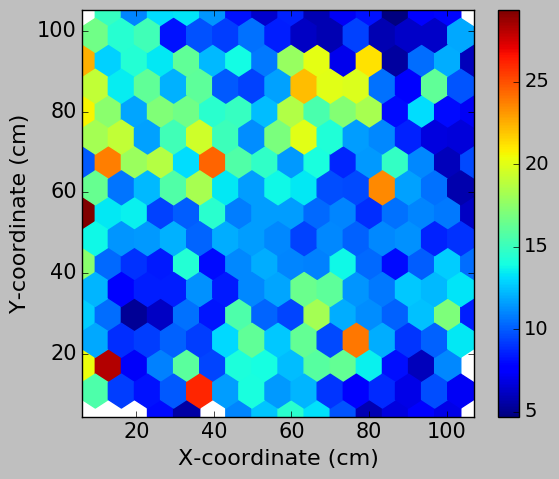

In [80]:
plt.figure(figsize=(5.2,5))
plt.plot(y[:,0], y[:,1], );
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
#plt.title("Trajectory of R2192")
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig("../trajectory.png")
plt.savefig("../trajectory.eps",format='eps')

plt.figure(figsize=(6,5))
#plt.title("Mean prediction error in different regions for R2192")
plt.hexbin(y[:,0], y[:,1],C=avg_errors, gridsize=15)
plt.xlabel("X-coordinate (cm)",fontsize=16)
plt.ylabel("Y-coordinate (cm)",fontsize=16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
cbar = plt.colorbar( ticks=[5,10,15,20,25])
cbar.ax.set_yticklabels([5,10,15,20,25],fontsize=14)
#cbar.ax.set_yticklabels(["5 cm","10 cm","15 cm","20 cm","25 cm"],fontsize=14)
#cbar.ax.set_title('Mean error',fontsize=14)
plt.tight_layout()
plt.savefig("../mean2D_10models.png")
plt.savefig("../mean2D_10models.eps",format='eps')

In [59]:
from matplotlib.collections import LineCollection


# Reshape things so that we have a sequence of:
# [[(x0,y0),(x1,y1)],[(x0,y0),(x1,y1)],...]
xy = xy.reshape(-1, 1, 2)
segments = np.hstack([xy[:-1], xy[1:]])

fig, ax = plt.subplots()
coll = LineCollection(segments, cmap=plt.cm.gist_ncar)
coll.set_array(np.random.random(xy.shape[0]))

ax.add_collection(coll)
ax.autoscale_view()

plt.show()

NameError: name 'xy' is not defined

In [60]:
xerrors = np.abs(avg_pred[:,0] - y[:,0])
yerrors = np.abs(avg_pred[:,1] - y[:,1])
print np.mean(xerrors), np.mean(yerrors)

7.46627230098 7.28041055537


Text(0.5,1,u'Y prediction error')

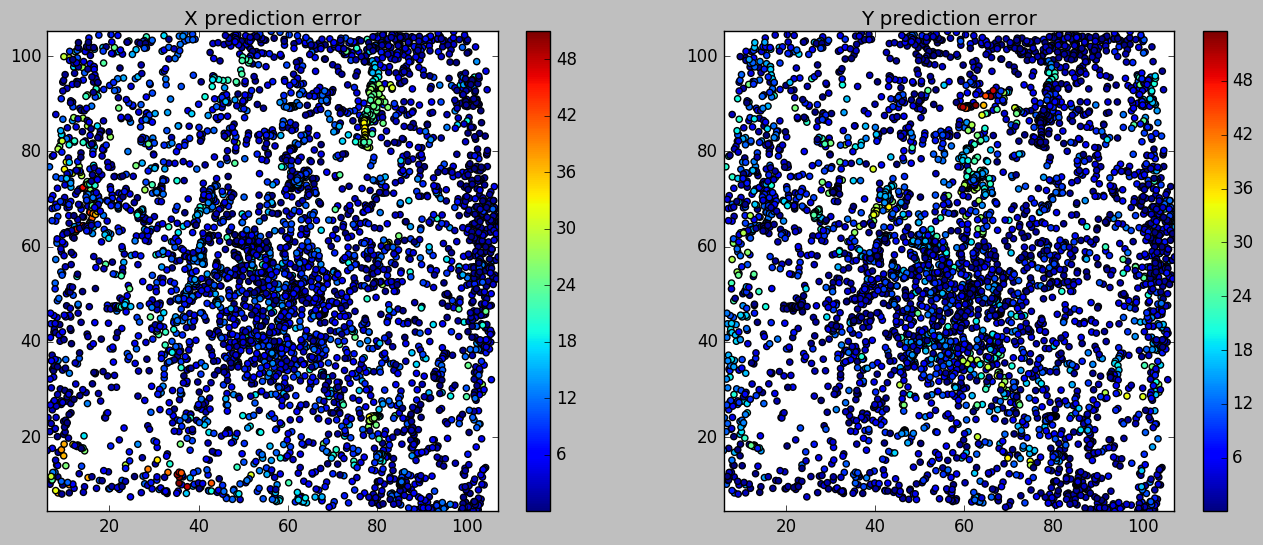

In [61]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.scatter(y[:,0], y[:,1],c=xerrors)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();
plt.title("X prediction error")
plt.subplot(1,2,2)
plt.scatter(y[:,0], y[:,1],c=yerrors)
plt.xlim([np.min(y[:,0]), np.max(y[:,0])])
plt.ylim([np.min(y[:,1]), np.max(y[:,1])])
plt.colorbar();
plt.title("Y prediction error")

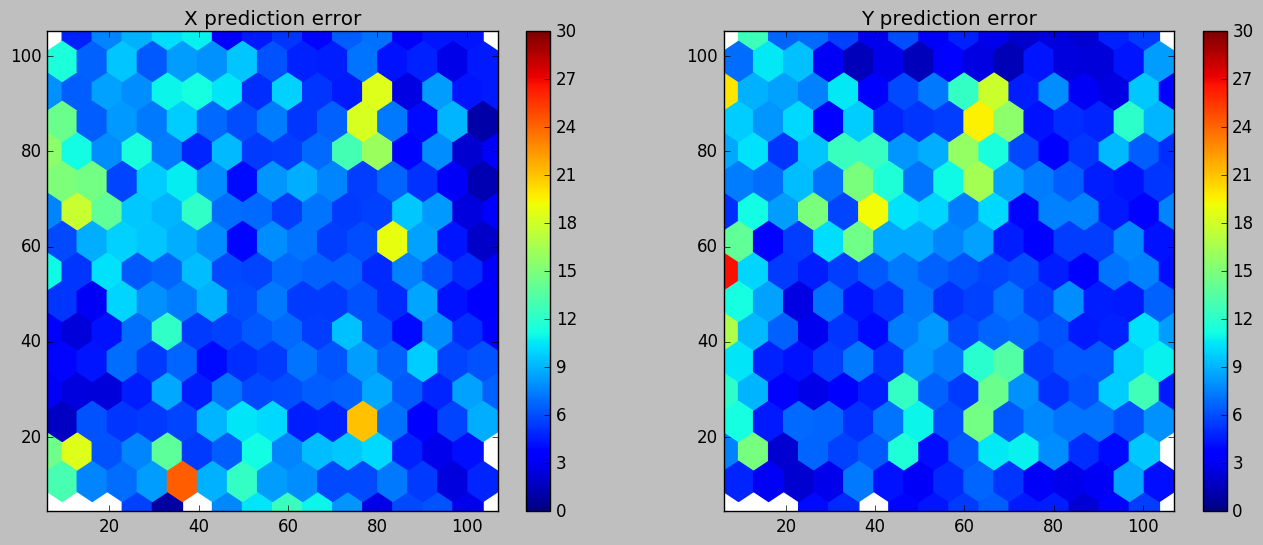

In [62]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title("X prediction error")
plt.hexbin(y[:,0], y[:,1],C=xerrors, gridsize=15, vmin=0, vmax=30)
plt.colorbar();
plt.subplot(1,2,2)
plt.title("Y prediction error")
plt.hexbin(y[:,0], y[:,1],C=yerrors, gridsize=15, vmin=0, vmax=30)
plt.colorbar();

(8828,) (8828,)


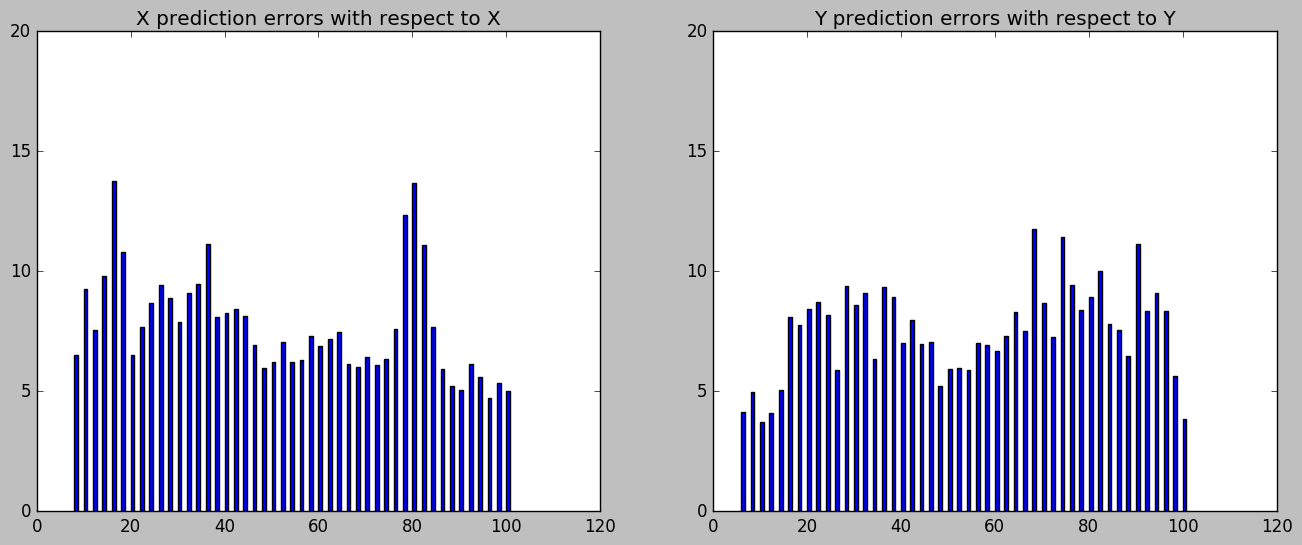

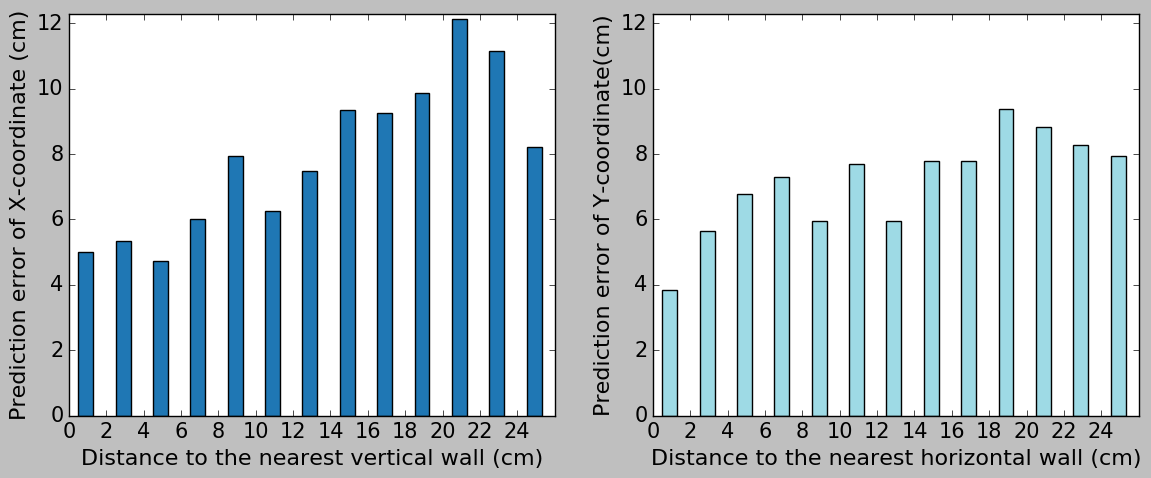

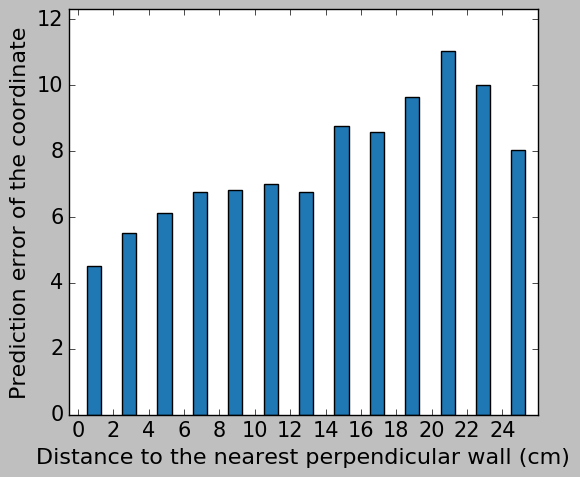

In [66]:
plt.figure(figsize=(16,6))
bins = np.arange(0,100.1, 2)

statistic, bin_edges, binnumber = binned_statistic(y[:,0], xerrors, statistic='mean', bins=bins)
plt.subplot(1,2,1)
plt.bar(bin_edges[1:], statistic)
plt.title("X prediction errors with respect to X")
plt.ylim([0,20])

statistic, bin_edges, binnumber = binned_statistic(y[:,1], yerrors, statistic='mean', bins=bins)
plt.subplot(1,2,2)
plt.bar(bin_edges[1:], statistic)
plt.title("Y prediction errors with respect to Y")
plt.ylim([0,20])


### the same but mirrored from the center - so we conider distnace from closest wall
bins = np.arange(0,50.1, 2)

plt.figure(figsize=(12,5))
nb_bins = 20

statisticX, bin_edgesX, binnumberX = binned_statistic(50-np.abs(y[:,0]-50), xerrors, statistic='mean', bins=bins)
plt.subplot(1,2,1)
plt.bar(bin_edgesX[1:]-1.5, statisticX, color=tableau20[0])
#plt.title("$Error_x = f(D_{vertical\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of X-coordinate (cm)",fontsize=16)
plt.xlabel("Distance to the nearest vertical wall (cm)",fontsize=16)
plt.ylim([0,12.3])
plt.xlim([0.5,26])
plt.xticks(np.arange(0,24.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)


statisticY, bin_edgesY, binnumberY = binned_statistic(50-np.abs(y[:,1]-50), yerrors, statistic='mean', bins=bins)
plt.subplot(1,2,2)
plt.bar(bin_edgesY[1:]-1.5, statisticY, color=tableau20[19])
#plt.title("$Error_y = f(D_{horizontal\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of Y-coordinate(cm)",fontsize=16)
plt.xlabel("Distance to the nearest horizontal wall (cm)",fontsize=16)
plt.ylim([0,12.3])
plt.xlim([0.5,26])
plt.xticks(np.arange(0,24.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.tight_layout()
plt.savefig("error_walls.png")

######################
plt.figure(figsize=(6,5))

all_1D_err = np.concatenate((xerrors,yerrors))
all_distances_to_wall = np.concatenate((50-np.abs(y[:,0]-50),50-np.abs(y[:,1]-50)))
print all_1D_err.shape, all_distances_to_wall.shape
statistic, bin_edges, binnumber = binned_statistic(all_distances_to_wall, all_1D_err, statistic='mean', bins=bins)
plt.bar(bin_edges[1:]-1.5, statistic, color=tableau20[0])
#plt.title("$Error_y = f(D_{horizontal\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of the coordinate",fontsize=16)
plt.xlabel("Distance to the nearest perpendicular wall (cm)",fontsize=16)
plt.ylim([0,12.3])
plt.xlim([-0.5,26])
plt.xticks(np.arange(0,24.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.tight_layout()
plt.savefig("error_walls_combined.png")

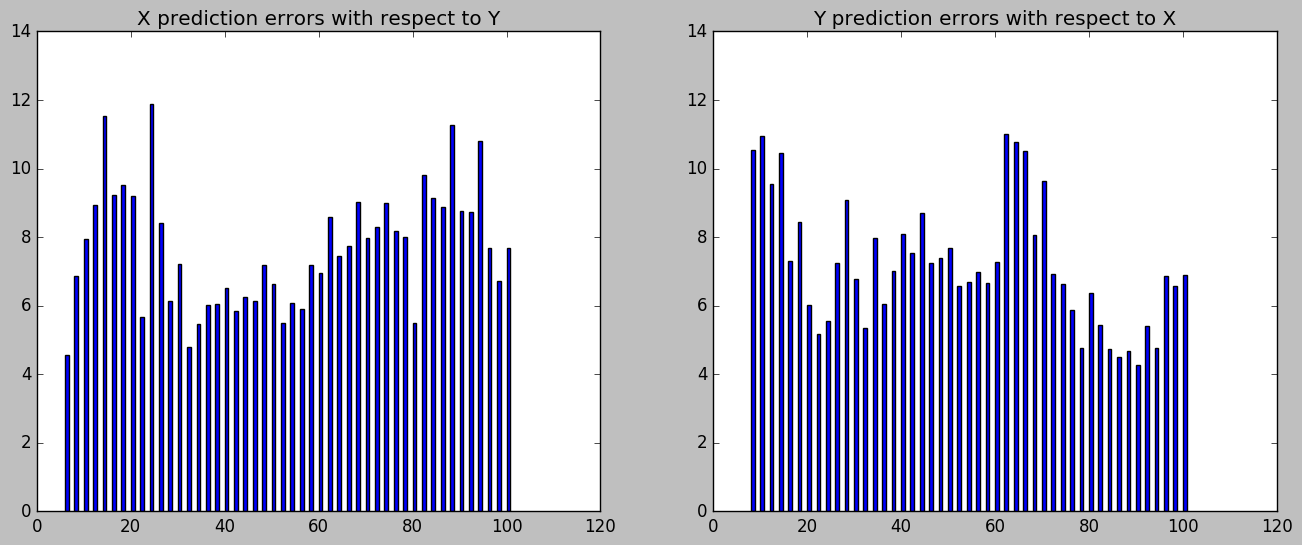

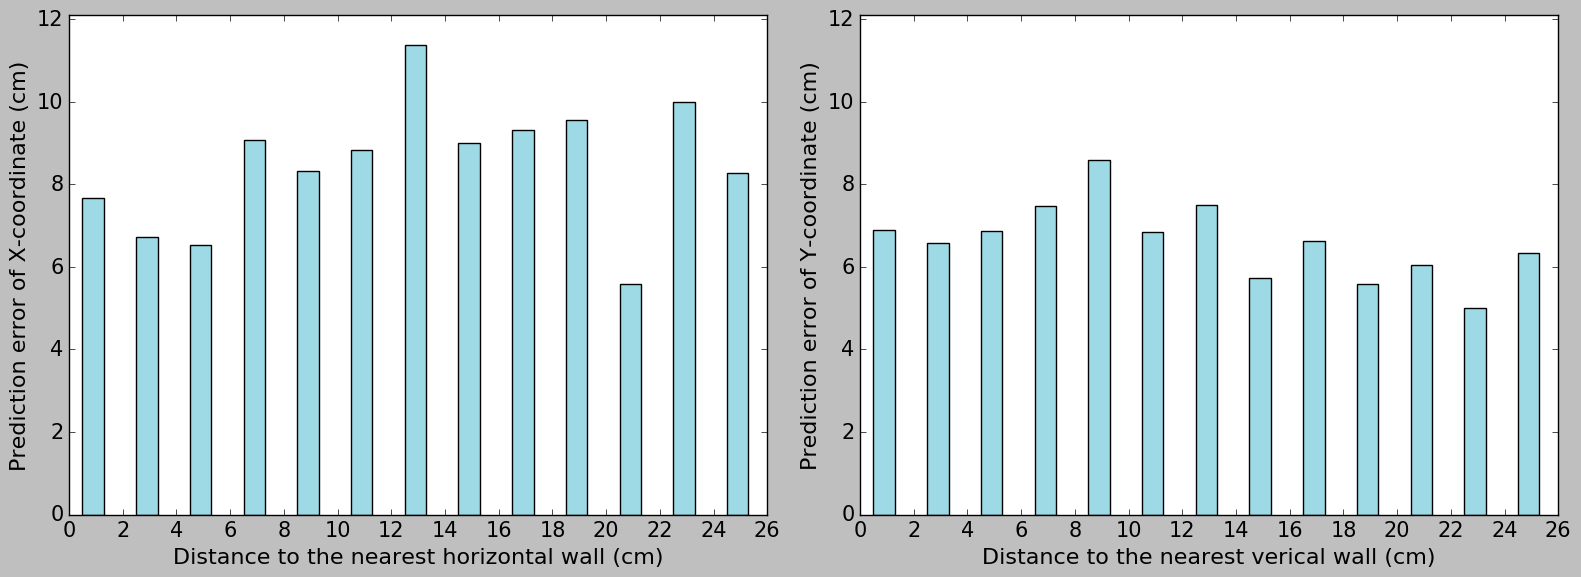

In [64]:
plt.figure(figsize=(16,6))
bins = np.arange(0,100.1, 2)

statistic, bin_edges, binnumber = binned_statistic(y[:,1], xerrors, statistic='mean', bins=bins)
plt.subplot(1,2,1)
plt.bar(bin_edges[1:], statistic)
plt.title("X prediction errors with respect to Y")
plt.ylim([0,14])

statistic, bin_edges, binnumber = binned_statistic(y[:,0], yerrors, statistic='mean', bins=bins)
plt.subplot(1,2,2)
plt.bar(bin_edges[1:], statistic)
plt.title("Y prediction errors with respect to X")
plt.ylim([0,14])

################# mirrored at the center
bins = np.arange(0,50.1, 2)
plt.figure(figsize=(16,6))
nb_bins = 20
statistic, bin_edges, binnumber = binned_statistic(50-np.abs(y[:,1]-50), xerrors, statistic='mean', bins=bins)
plt.subplot(1,2,1)
plt.bar(bin_edges[1:]-1.5, statistic, color=tableau20[19])
#plt.title("$Error_x = f(D_{horizontal\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of X-coordinate (cm)",fontsize=16)
plt.xlabel("Distance to the nearest horizontal wall (cm)",fontsize=16)
plt.ylim([0,13])
plt.xlim([0.5,26])
plt.xticks(np.arange(0,26.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.ylim([0,12.1])



statistic, bin_edges, binnumber = binned_statistic(50-np.abs(y[:,0]-50), yerrors, statistic='mean', bins=bins)
plt.subplot(1,2,2)
plt.bar(bin_edges[1:]-1.5, statistic, color=tableau20[19])
#plt.title("$Error_y = f(D_{vertical\_wall})$ ",fontsize=17)
plt.ylabel("Prediction error of Y-coordinate (cm)",fontsize=16)
plt.xlabel("Distance to the nearest verical wall (cm)",fontsize=16)
plt.ylim([0,13])
plt.xlim([0.5,26])
plt.xticks(np.arange(0,26.1,2),fontsize=15)
plt.yticks(np.arange(0,12.1,2),fontsize=15)
plt.ylim([0,12.1])
plt.tight_layout()
plt.savefig("error_walls_parallel.png")

In [73]:
from scipy.stats import pearsonr,spearmanr
# HOW ABOUT STATISTICAL SIGNIFICANCE ?

all_1D_err = np.concatenate((xerrors,yerrors))
all_distances_to_wall = np.concatenate((50-np.abs(y[:,0]-50),50-np.abs(y[:,1]-50)))

#we are only interested in the zone near the walls
zone_near_wall_idx = np.where(all_distances_to_wall<25.001)

#extract data from region of interest (ROI)
roi_errs = all_1D_err[zone_near_wall_idx]
roi_wall_dists = all_distances_to_wall[zone_near_wall_idx]
#plt.plot( roi_wall_dists,roi_errs, "o")
print " Errors combined: spearman .......", spearmanr(roi_errs,roi_wall_dists), len(roi_errs)


## for X coord alone
all_errs = xerrors
all_distances_to_wall = 50-np.abs(y[:,0]-50)

zone_near_wall_idx = np.where(all_distances_to_wall<25.001)
roi_errs = all_errs[zone_near_wall_idx]
roi_wall_dists = all_distances_to_wall[zone_near_wall_idx]
print " X-coord Errors : spearman .......", spearmanr(roi_errs,roi_wall_dists), len(roi_errs)

## for Y coord alone
all_errs = yerrors
all_distances_to_wall = 50-np.abs(y[:,1]-50)
zone_near_wall_idx = np.where(all_distances_to_wall<25.001)
roi_errs = all_errs[zone_near_wall_idx]
roi_wall_dists = all_distances_to_wall[zone_near_wall_idx]
print "  Y-coord Errors : spearman .......", spearmanr(roi_errs,roi_wall_dists), len(roi_errs)


 Errors combined: spearman ....... SpearmanrResult(correlation=0.30841427082876083, pvalue=5.09538127632798e-88) 3960
 X-coord Errors : spearman ....... SpearmanrResult(correlation=0.353731659027682, pvalue=5.0615382187366985e-63) 2103
  Y-coord Errors : spearman ....... SpearmanrResult(correlation=0.24929698947207179, pvalue=1.0511846509469062e-27) 1857


In [75]:
diff = y[1:,:] - y[:-1,:]
print diff.shape

(4413, 2)


In [76]:
dists = np.sqrt(np.sum(diff**2, axis=1))
print dists.shape, np.mean(dists)

(4413,) 3.7924232812


edges [ 441  883 1325 1767 2208 2649 3090 3531 3972]
[ 44.85415513  58.60256619  62.25931673  72.85410459  83.4080241
  80.84225341  58.59452233  46.34623049  56.57595575]
remianing largest speed is 14.6422197641
count [ 483.  908.  670.  445.  426.  336.  263.  276.  197.  160.  100.   75.
   35.   24.] len 14 15
[ -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5
  11.5  12.5  13.5] 14 [ 16.45198588  13.81603617  12.10556906  11.93469928  11.63889985
  11.21829538  10.69601339  10.62558836  11.27291365  10.88712665
  11.9685629   12.03223589  11.05775632  12.9643255 ]
[ -0.5   0.5   1.5   2.5   3.5   4.5   5.5   6.5   7.5   8.5   9.5  10.5
  11.5  12.5  13.5] 14 [ 15.73170179  11.99434384  10.04919404   9.59301674   9.42169044
   9.55983762   9.39607895   9.51604642   9.32998247   9.44069229
   9.25161191  11.00430458   9.79470645  11.15339673]
#############################################
STDs are way too huge [ 8.67770731  8.72249773  7.6965568   8.26884757  7.

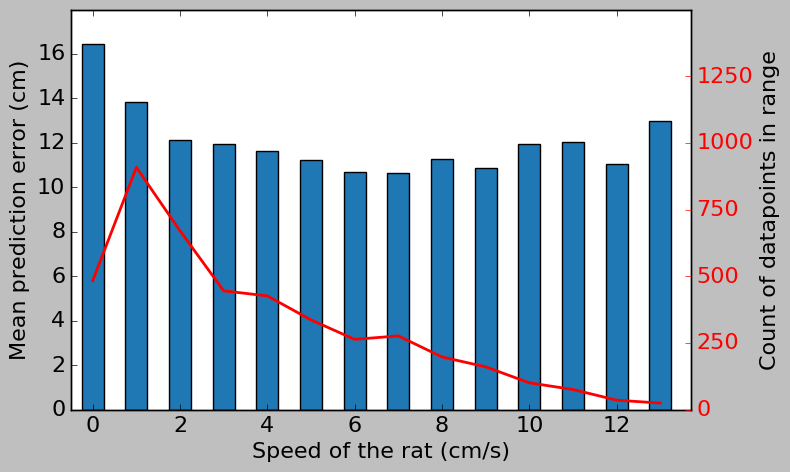

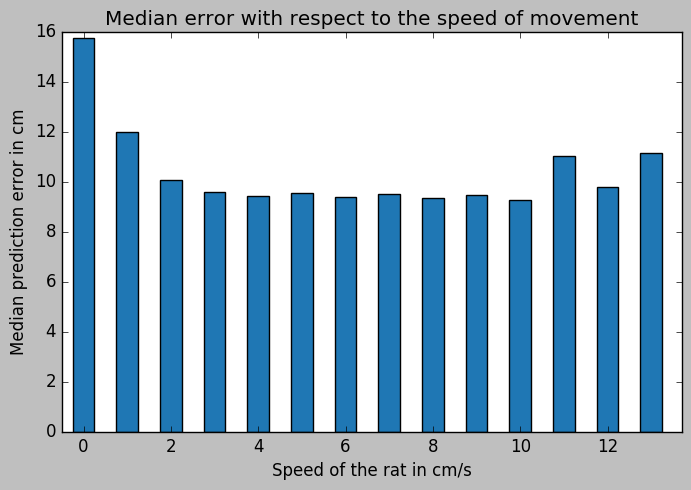

In [77]:
#plt.style.use("ggplot")

edges=np.cumsum([441,442,442,442,441,441,441,441,441])
print "edges", edges
print dists[edges]

dists_wo_edges = np.delete(dists, edges)
errors_wo_edges = np.delete(avg_errors[1:],edges)
#errors_wo_edges = np.delete(median_errors[1:],edges)
print "remianing largest speed is", np.max(dists_wo_edges)

count_in_bin, bin_edges, binnumber = binned_statistic(dists_wo_edges, errors_wo_edges, statistic='count',
                                                   bins=np.arange(-0.5,13.6,1))
print "count",count_in_bin, "len", len(count_in_bin), len(np.arange(-0.5,13.6,1))

statistic, bin_edges, binnumber = binned_statistic(dists_wo_edges, errors_wo_edges, statistic='mean',
                                                   bins=np.arange(-0.5,13.6,1))
print bin_edges, len(statistic), statistic

fig, ax1 = plt.subplots(figsize=(8,5))#8,5 seems thebesty, 7,4 is ok
ax2 = ax1.twinx()

ax1.bar(bin_edges[:-1]+0.25, statistic, width=0.5, color=tableau20[0]);
ax1.set_xlim([-0.5,13.7])
#ax1.set_title("Mean error with respect to the speed of movement", fontsize=15)
ax1.set_xlabel("Speed of the rat (cm/s)", fontsize=16)
ax1.set_ylabel("Mean prediction error (cm)", fontsize=16)
ax1.tick_params(labelsize=16)
ax1.set_yticks([0,2,4,6,8,10,12,14,16])


ax2.plot(range(14),count_in_bin,color="r", linewidth=2)
ax2.set_ylabel("Count of datapoints in range", fontsize=16)
ax2.set_ylim([0,1500])
ax2.tick_params(colors='r',labelsize=16)
ax2.set_yticks([0,250,500,750,1000,1250])


fig.savefig("speed_with_count.png")


#print avg_errors[:10], median_errors[:10], np.mean(avg_errors),np.mean(median_errors)
errors_wo_edges = np.delete(avg_errors[1:],edges)

statistic, bin_edges, binnumber = binned_statistic(dists_wo_edges, errors_wo_edges, statistic='median',
                                                   bins=np.arange(-0.5,13.6,1))
print bin_edges, len(statistic), statistic
plt.figure(figsize=(8,5))
plt.bar(bin_edges[:-1]+0.25, statistic, width=0.5, color=tableau20[0]);
plt.xlim([-0.5,13.7])
plt.title("Median error with respect to the speed of movement")
plt.xlabel("Speed of the rat in cm/s")
plt.ylabel("Median prediction error in cm")

print "#############################################"
statistic, bin_edges, binnumber = binned_statistic(dists_wo_edges, errors_wo_edges, statistic=np.std,
                                                   bins=np.arange(-0.5,13.6,1))
print "STDs are way too huge",statistic

print "speed in first bin",dists_wo_edges[np.where(binnumber==1)[0]][:5]
print np.mean(errors_wo_edges[np.where(binnumber==1)[0]])
print np.std(errors_wo_edges[np.where(binnumber==1)[0]])

print "\n speeds above 0.5 cm/s:"
print np.mean(errors_wo_edges[np.where(binnumber>1)[0]])
print np.std(errors_wo_edges[np.where(binnumber>1)[0]])

print "\n speeds above 1.5 cm/s:"
print np.mean(errors_wo_edges[np.where(binnumber>2)[0]])
print np.std(errors_wo_edges[np.where(binnumber>2)[0]])

print "\n speeds above 9.5 cm/s:"
print np.mean(errors_wo_edges[np.where(binnumber>11)[0]])
print np.std(errors_wo_edges[np.where(binnumber>11)[0]])

print "\n speeds above 12.5 cm/s:"
print np.mean(errors_wo_edges[np.where(binnumber>13)[0]])
#print np.mean(errors_wo_edges[np.where(dists_wo_edges>12.5)[0]])  #just a sanity check!
print np.std(errors_wo_edges[np.where(binnumber>13)[0]])

In [79]:
# STATS FOR SPEED RESULTS

from scipy import stats

# we want two-sided and no restriction on variance (beacuse not equal var)

standing_still = errors_wo_edges[np.where(dists_wo_edges < 0.5)[0]]
in_motion = errors_wo_edges[np.where(dists_wo_edges > 0.5)[0]]
normal_motion = errors_wo_edges[np.where(np.logical_and(dists_wo_edges > 0.5, dists_wo_edges <10.5))[0]]
fast_speed = errors_wo_edges[np.where(dists_wo_edges > 10.5)[0]]

print stats.ttest_ind(standing_still,in_motion, equal_var=False)

print stats.ttest_ind(normal_motion,fast_speed, equal_var=False)


Ttest_indResult(statistic=10.619823773035726, pvalue=3.3967303748942815e-24)
Ttest_indResult(statistic=0.31259001754545862, pvalue=0.7550141549760705)


In [74]:
angles = np.arctan2(diff[:,1], diff[:,0])
print angles.shape

print avg_errors.shape

(4413,)
(4414,)


In [99]:
nb_bins = 72
statistic, bin_edges, binnumber = binned_statistic(angles, avg_errors[1:], statistic='mean', bins=nb_bins)
print len(bin_edges), len(statistic)

73 72


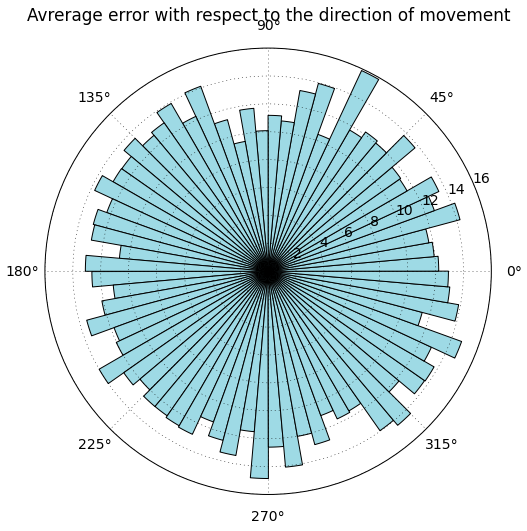

In [106]:
plt.figure(figsize=(8,8))
plt.gca(projection='polar')
plt.rcParams.update({'font.size': 14})
plt.bar(bin_edges[:-1], statistic, width=2*math.pi/nb_bins, color=tableau20[19]);
plt.title("Avrerage error with respect to the direction of movement")


[ 33.97751  29.47693  24.0593   22.54227  19.26453  18.16817  16.85692
  15.27255  14.38027  13.53828  13.38037] [ 2.47135109  1.83830984  1.25721702  1.6036862   1.65612491  1.12046656
  1.07252537  0.56282838  0.42194757  0.43544076  0.55268663]
(11, 10) [ 47.8641194   39.56264066  33.04849566  28.95395691  25.70864714
  23.90454148  22.94703457  20.55789786  19.88303774  18.82196011
  18.65398065]


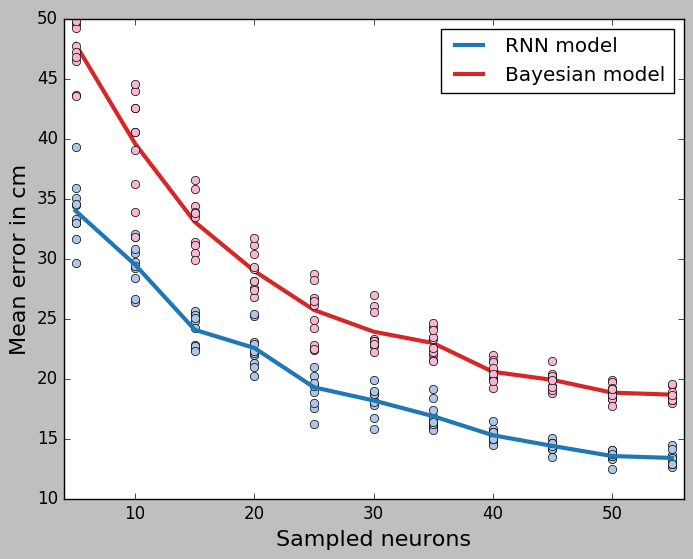

[ 30.8877  26.0346  20.1356  18.1399  15.3809  14.5888  13.4009  12.0662
  11.542   10.9294  10.8329] [ 3.14644651  2.17261705  1.33738253  1.47245438  1.36433716  0.90770456
  0.73703642  0.39425241  0.31285556  0.29637753  0.30768928]
[ 46.036119    33.75789005  25.22884366  20.5592003   17.90048752
  16.31563567  15.20739504  13.6990402   13.29739348  12.61524866
  12.55239352]


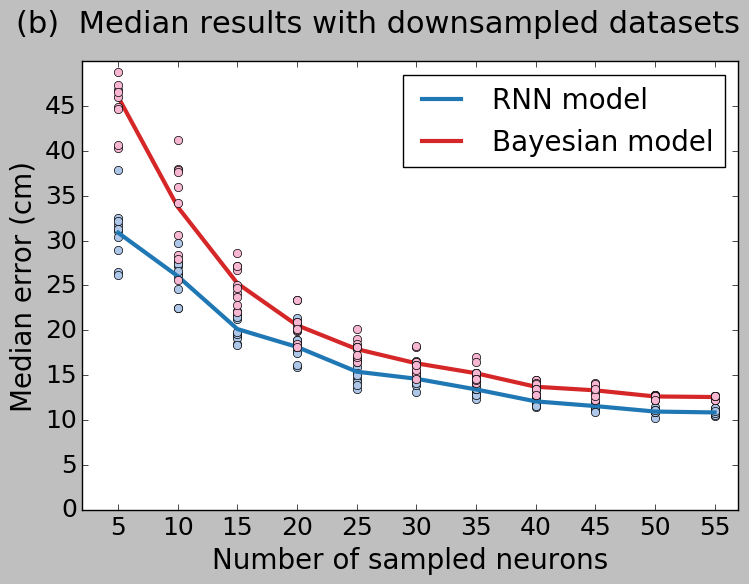

In [25]:
f=np.loadtxt("R2192_models/downsample/means_and_medians.txt",dtype=str)
mea_and_med = f[:,[-5,-1]]
mea_and_med[:,0] = map(lambda x: float(x[:-1]),mea_and_med[:,0] )
mea_and_med[:,1] = map(lambda x: float(x[:-1]),mea_and_med[:,1] )

mea_and_med= np.array(mea_and_med,dtype=float)

sample_sizes=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
              10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
              15, 15, 15, 15, 15, 15, 15, 15, 15, 15,
              20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
              25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
              30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
              35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
              40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
              45, 45, 45, 45, 45, 45, 45, 45, 45, 45,
              50, 50, 50, 50, 50, 50, 50, 50, 50, 50,
              55, 55, 55, 55, 55, 55, 55, 55, 55, 55]

plt.plot(sample_sizes,mea_and_med[:,0],'o',color=tableau20[1])
plt.xlim([4,56])
#print np.reshape(mea_and_med[:,1],(5,10))
mean_of_means = np.mean(np.reshape(mea_and_med[:,0],(11,10)),axis=1)
plt.plot([5,10,15,20,25,30,35,40,45,50,55],mean_of_means,color=tableau20[0], linewidth=3,label="RNN model")
plt.ylabel("Mean error in cm",fontsize=16)
plt.xlabel("Sampled neurons",fontsize=16)
print mean_of_means, np.std(np.reshape(mea_and_med[:,0],(11,10)),axis=1)

#bay = np.array([[10,39.6,33.8],[15, 33.0, 25.2],[20, 29.0, 20.6],[30, 23.9, 16.3],[40, 20.6, 13.7]])
bay_means = np.loadtxt("caswell_res/bayes_downsample_mean.txt",delimiter=",",dtype=float)
print bay_means.shape, np.mean(bay_means,axis=1)
plt.plot([5,10,15,20,25,30,35,40,45,50,55],np.mean(bay_means,axis=1),color=tableau20[6], linewidth=3,label="Bayesian model")
plt.plot(sample_sizes,bay_means.flatten(),'o',color=tableau20[13])
plt.ylim([10,50])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))

plt.clf()
plt.plot(sample_sizes,mea_and_med[:,1],'o',color=tableau20[1])
plt.xlim([2,57])
#print np.reshape(mea_and_med[:,1],(5,10))
mean_of_medians = np.mean(np.reshape(mea_and_med[:,1],(11,10)),axis=1)
plt.plot([5,10,15,20,25,30,35,40,45,50,55],mean_of_medians,color=tableau20[0],label="RNN model",linewidth=3)
plt.ylabel("Median error (cm)",fontsize=20)
plt.xlabel("Number of sampled neurons",fontsize=20)


bay_medians = np.loadtxt("caswell_res/bayes_downsample_median.txt",delimiter=",",dtype=float)
plt.plot([5,10,15,20,25,30,35,40,45,50,55],np.mean(bay_medians,axis=1),color=tableau20[6], linewidth=3,label="Bayesian model")
plt.plot(sample_sizes,bay_medians.flatten(),'o',color=tableau20[13])
plt.ylim([8,50])
plt.yticks([0,5,10,15,20,25,30,35,40,45],fontsize=18)
plt.xticks([5,10,15,20,25,30,35,40,45,50,55],fontsize=18)
print mean_of_medians, np.std(np.reshape(mea_and_med[:,1],(11,10)),axis=1)
print np.mean(bay_medians,axis=1)

plt.legend(fontsize=20)
plt.title("(b)  Median results with downsampled datasets",fontsize=22, y=1.05,x=0.45)
plt.tight_layout()
plt.savefig("med_down.png")
